In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, accuracy_score

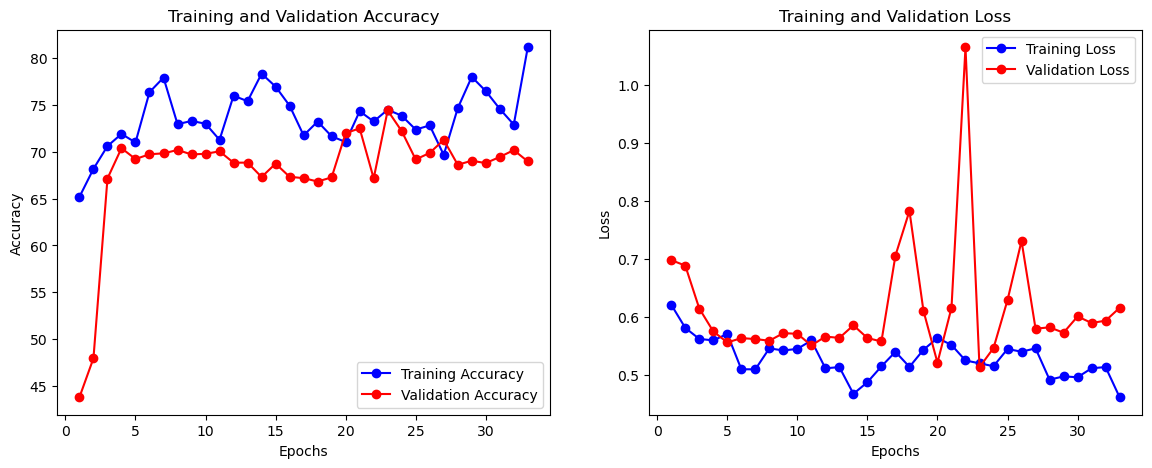

In [9]:
# First plot the training and validation accuracy of the model
# Set the base path for the metrics
base_path = '/Users/kieranmartin/Desktop/Spring 2024/Computer_Vision_Deep_Learning/Final Project/mlruns/840866308247614415/f795b78c9fba45e69f99a8002440135b'
metrics_path = os.path.join(base_path, 'metrics')

# Load metric values
def load_metric(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Extract the second value in each line and convert it to float
        return [float(line.split()[1]) for line in lines]

train_accuracy = load_metric(os.path.join(metrics_path, 'train_accuracy'))
val_accuracy = load_metric(os.path.join(metrics_path, 'val_accuracy'))
train_loss = load_metric(os.path.join(metrics_path, 'train_loss'))
val_loss = load_metric(os.path.join(metrics_path, 'val_loss'))

# Plot Accuracy and Loss
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

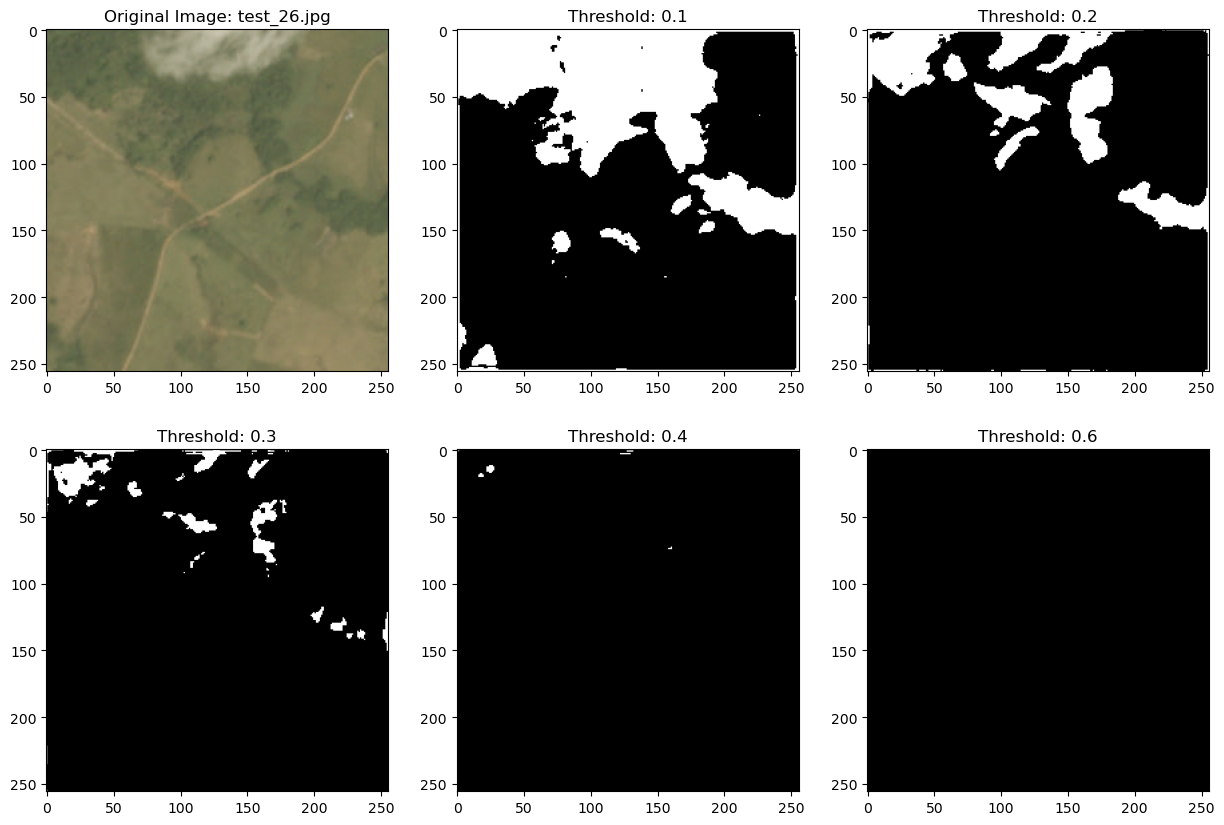

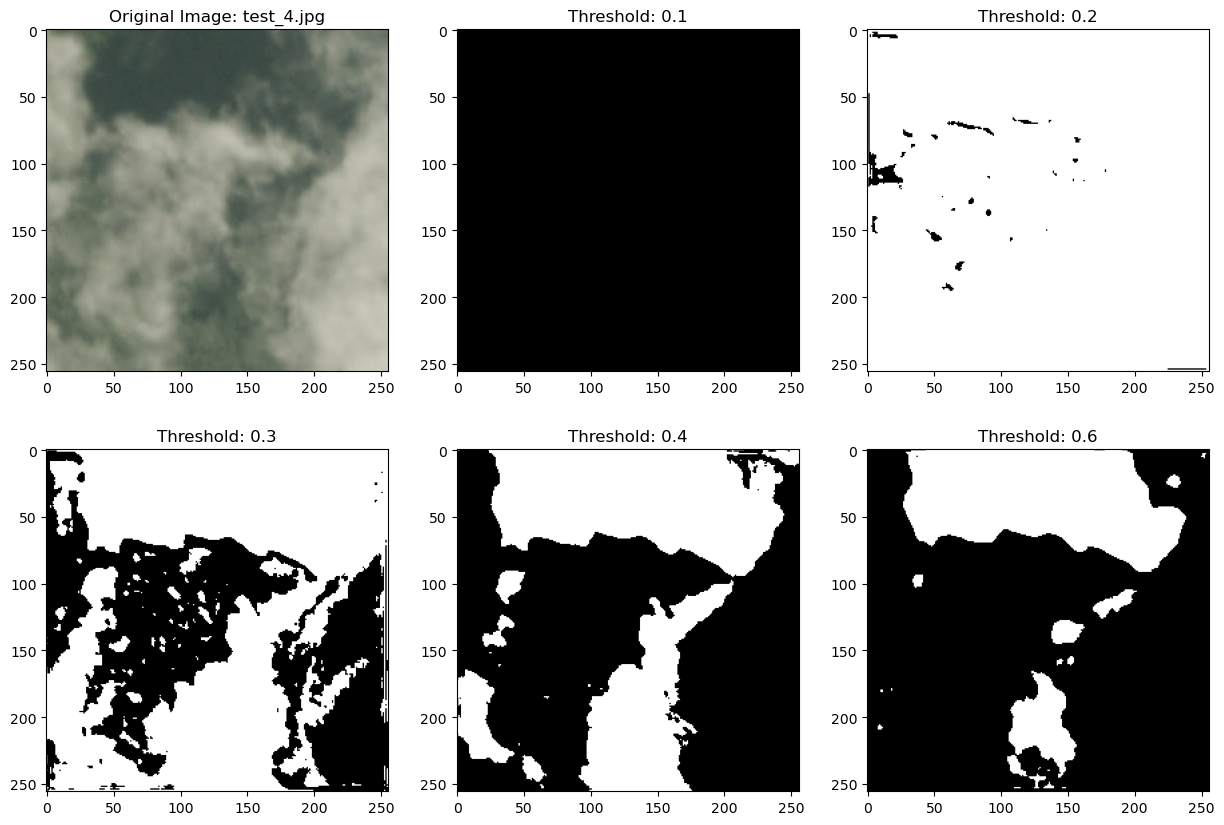

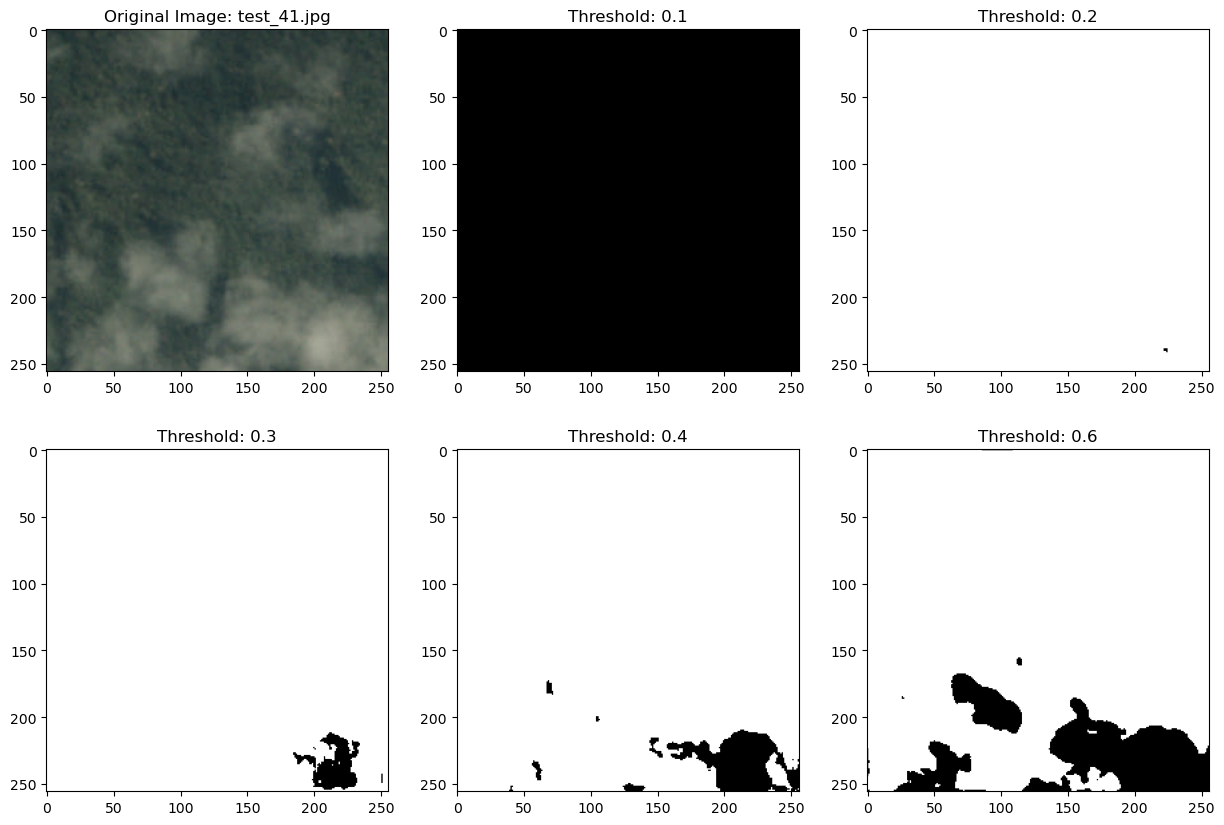

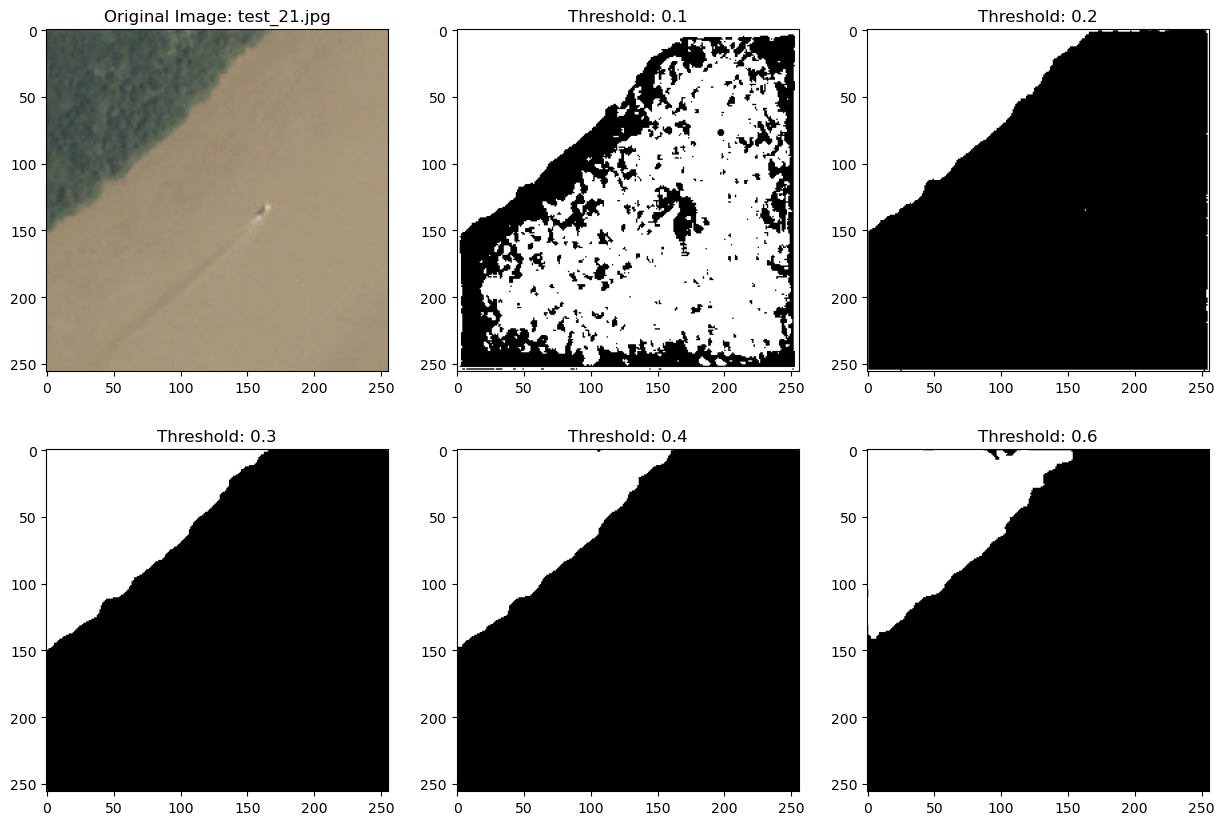

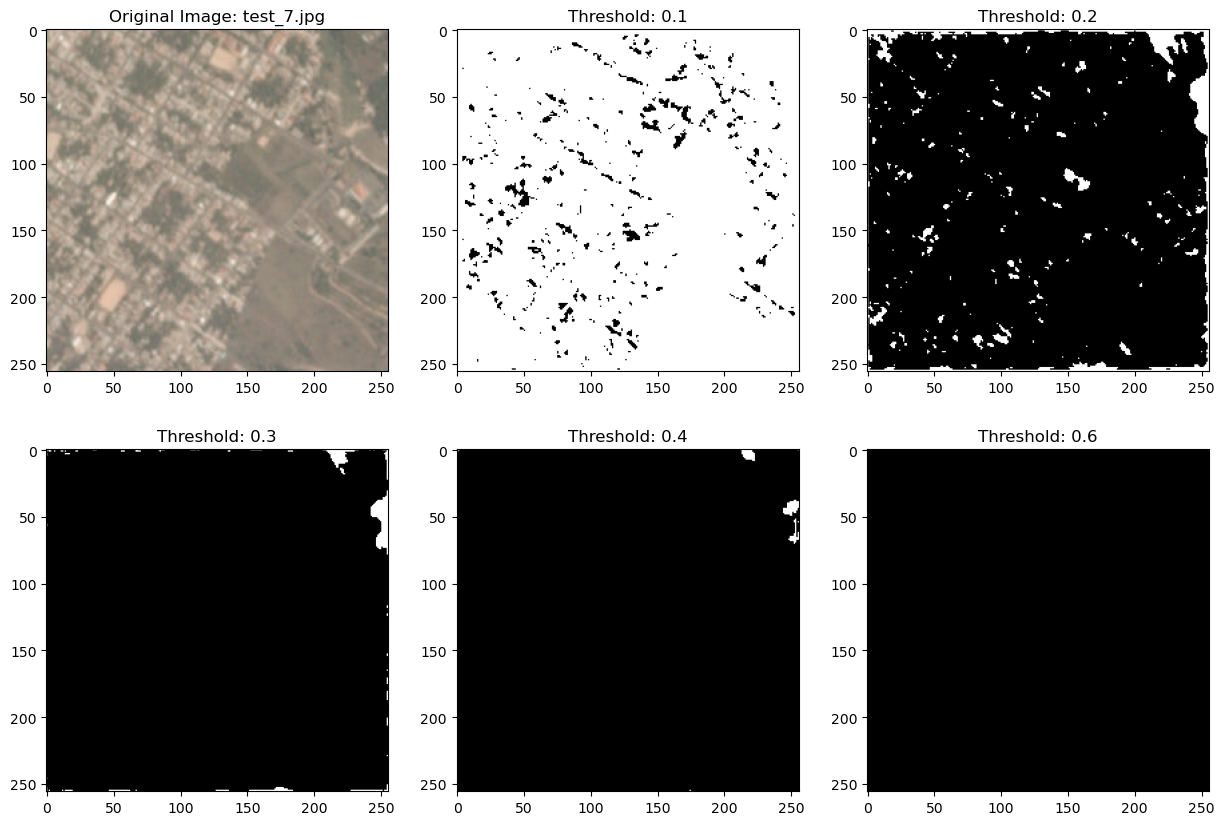

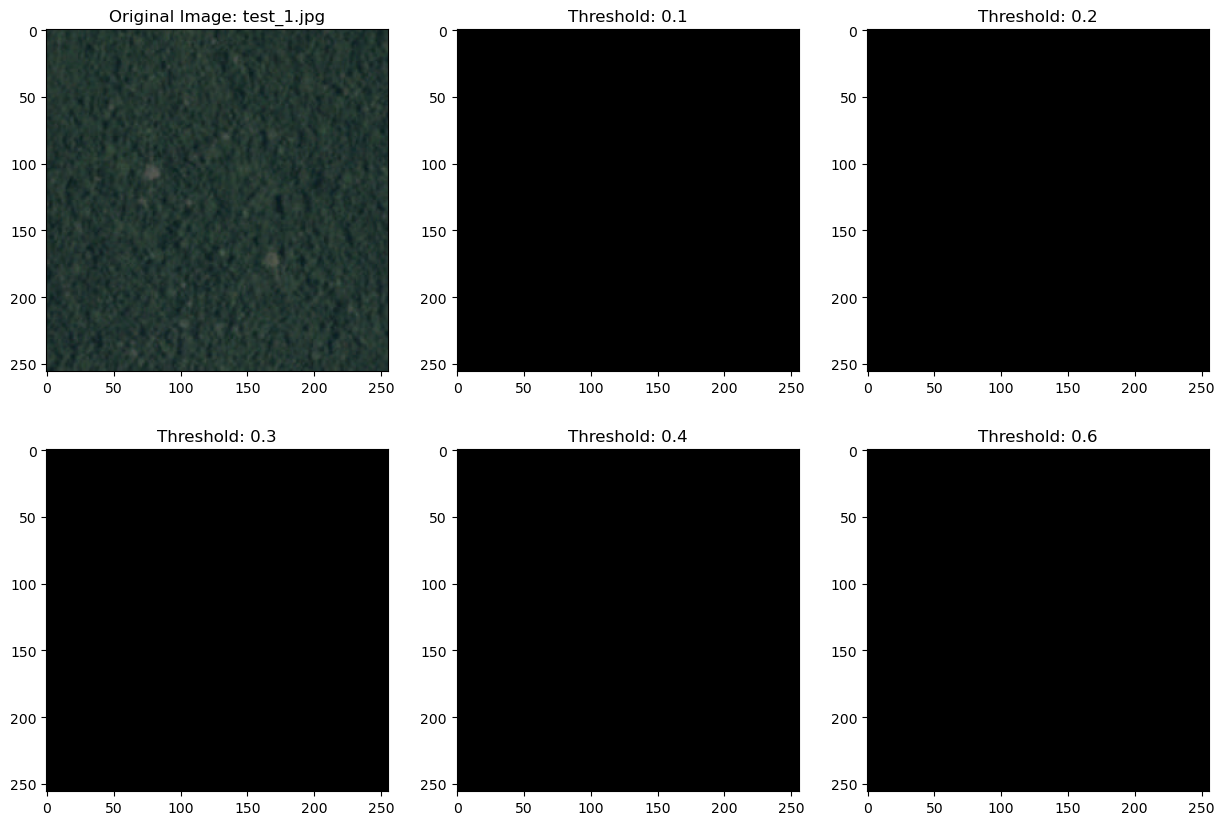

In [10]:
# Change path to call model and test on unseen data
import sys
sys.path.append('/Users/kieranmartin/Desktop/Spring 2024/Computer_Vision_Deep_Learning/Final Project')
from model import UNet


model_checkpoint_path = '/Users/katherinemartin/Desktop/Spring 2024/Computer_Vision_Deep_Learning/Final Project/best_unet_modelv2.pth'

# Testing U-Net on Unseen Data
test_images_path = '/Users/kieranmartin/Desktop/Spring 2024/Computer_Vision_Deep_Learning/Final Project/datasets/identdeforest/test'
test_images = ['test_26.jpg', 'test_4.jpg', 'test_41.jpg', 'test_21.jpg', 'test_7.jpg', 'test_1.jpg']

# Match image transformation to training
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_classes=1).to(device)
checkpoint = torch.load(model_checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Function to make prediction with adjustable threshold
def predict(image, threshold=0.5):
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        prediction = (output > threshold).float().cpu().numpy()
    return prediction

# Function to visualize prediction with original image and predicted masks for multiple thresholds
def visualize_prediction(image_path, predictions, thresholds, image_name):
    image = Image.open(image_path).convert('RGB')
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.title(f'Original Image: {image_name}')
    plt.imshow(image)
    
    for i, (prediction, threshold) in enumerate(zip(predictions, thresholds)):
        plt.subplot(2, 3, i+2)
        plt.title(f'Threshold: {threshold}')
        plt.imshow(prediction.squeeze(), cmap='gray')
    
    plt.show()

# Define the threshold values to test
thresholds = [0.1, 0.2, 0.3, 0.4, 0.6]

# Test the model on the specified images with different thresholds
for image_name in test_images:
    image_path = os.path.join(test_images_path, image_name)
    image = load_image(image_path)
    predictions = [predict(image, threshold) for threshold in thresholds]
    visualize_prediction(image_path, predictions, thresholds, image_name)


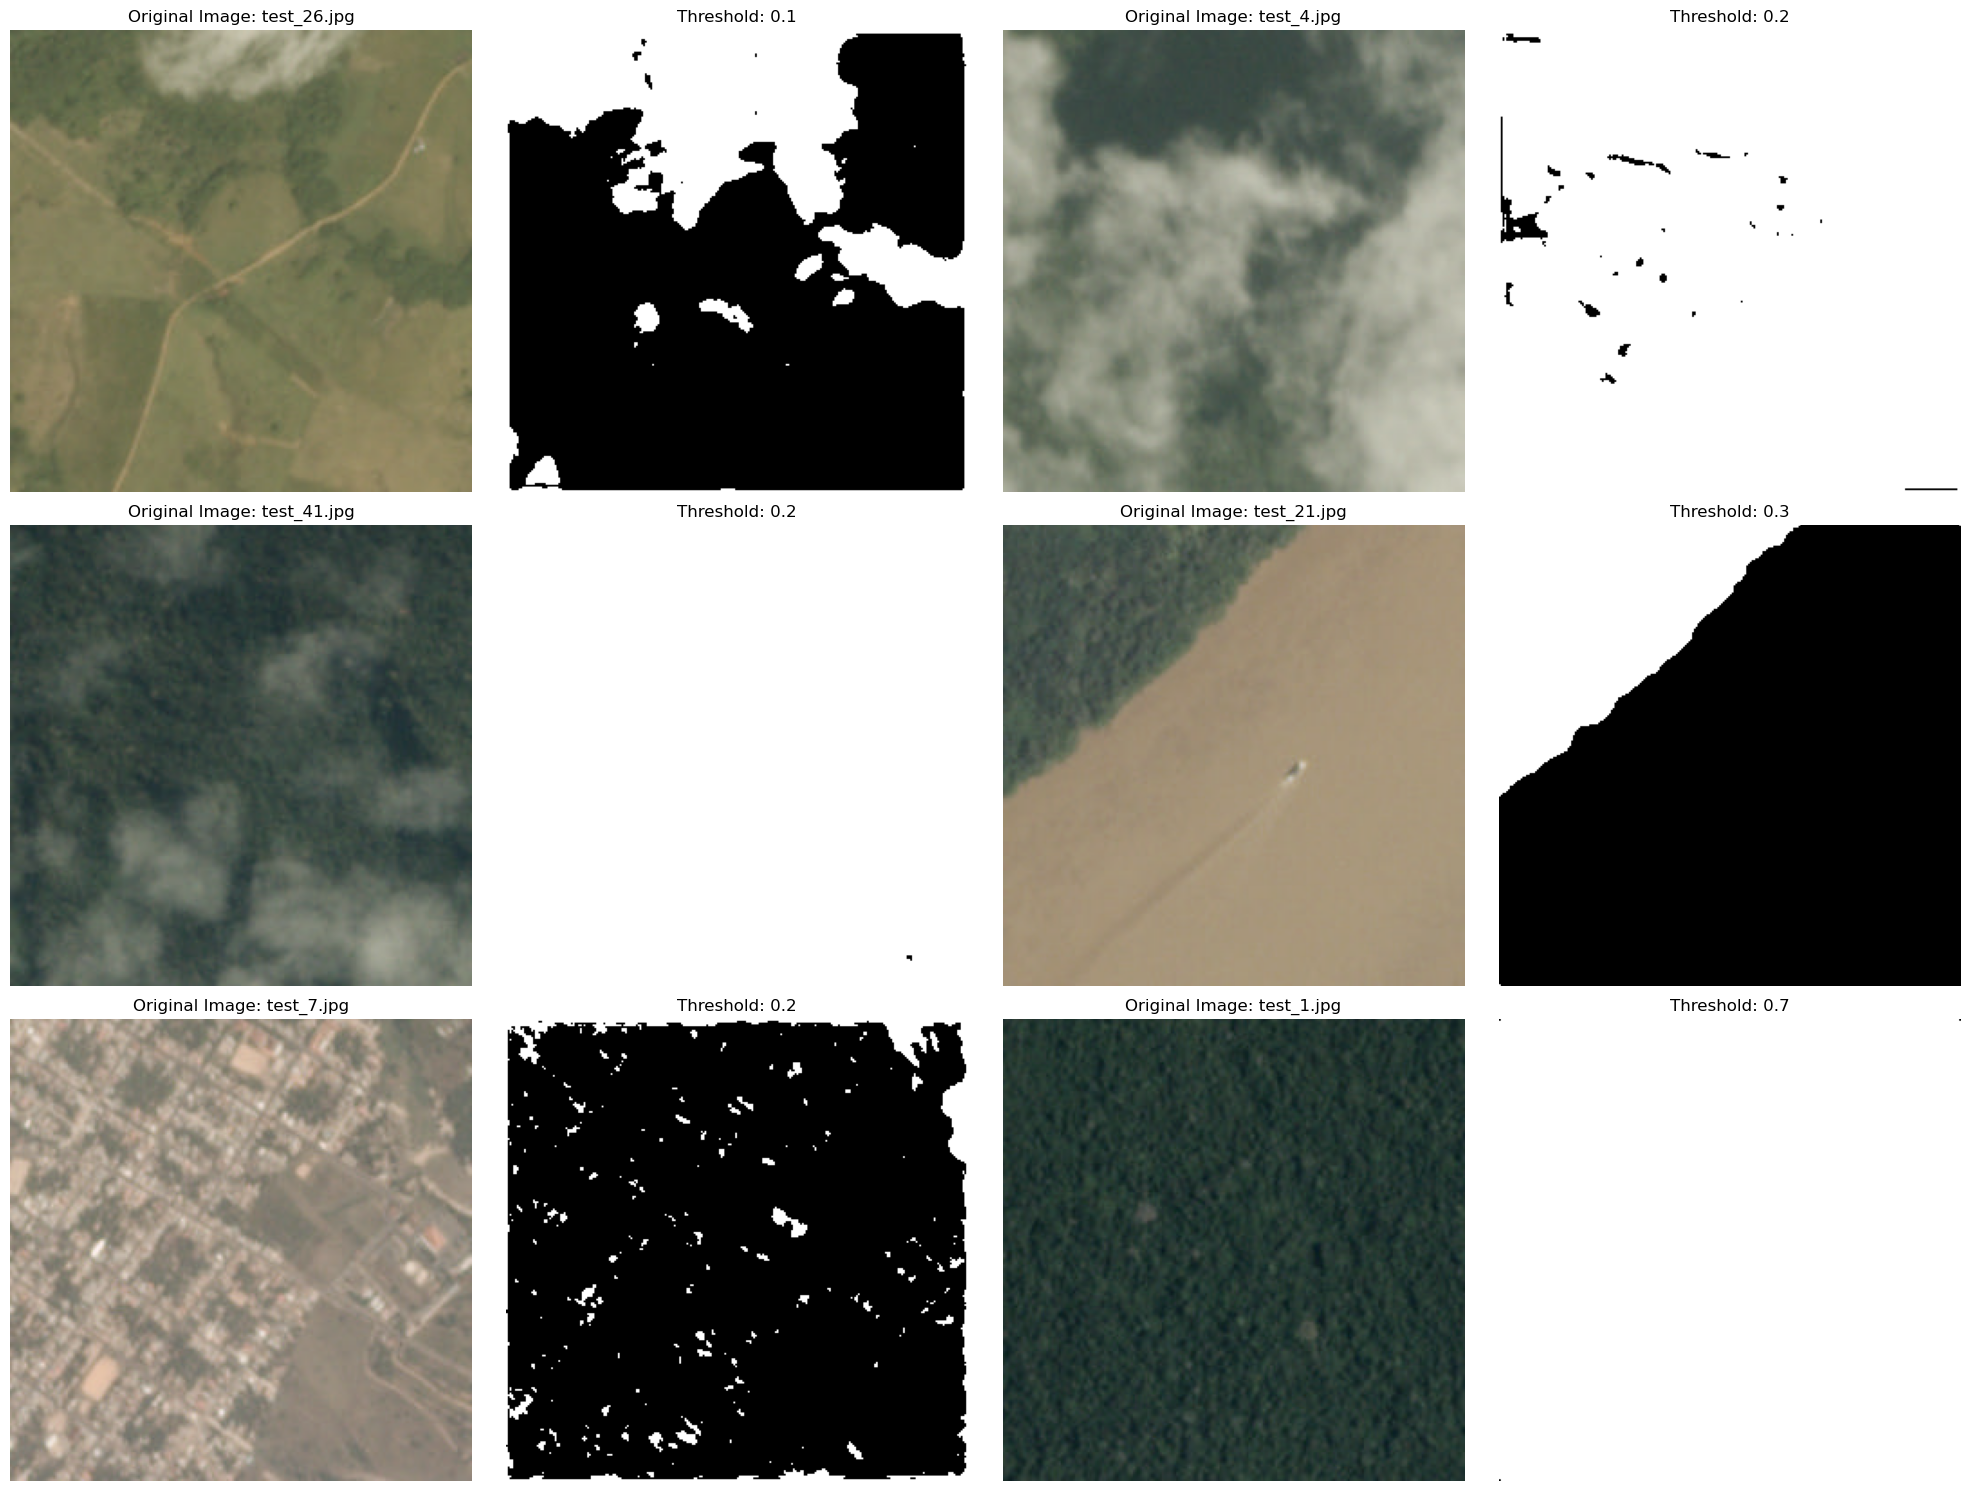

In [3]:
# Define the best threshold for each image
best_thresholds = {
    'test_26.jpg': 0.1,
    'test_4.jpg': 0.2,
    'test_41.jpg': 0.2,
    'test_21.jpg': 0.3,
    'test_7.jpg': 0.2,
    'test_1.jpg': 0.7
}


# Function to visualize the original images and their predicted masks at the best thresholds
def visualize_predictions(image_paths, predictions, thresholds, image_names):
    num_images = len(image_paths)
    plt.figure(figsize=(20, 15))

    for i, (image_path, prediction, threshold, image_name) in enumerate(zip(image_paths, predictions, thresholds, image_names)):
        image = Image.open(image_path).convert("RGB")

        plt.subplot(3, 4, 2 * i + 1)
        plt.title(f"Original Image: {image_name}")
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(3, 4, 2 * i + 2)
        plt.title(f"Threshold: {threshold}")
        plt.imshow(prediction.squeeze(), cmap="gray")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prepare the data for visualization
image_paths = [os.path.join(test_images_path, image_name) for image_name in test_images]
best_thresholds_list = [best_thresholds[image_name] for image_name in test_images]
predictions = [predict(load_image(image_path), best_threshold) for image_path, best_threshold in zip(image_paths, best_thresholds_list)]

# Visualize the predictions
visualize_predictions(image_paths, predictions, best_thresholds_list, test_images)


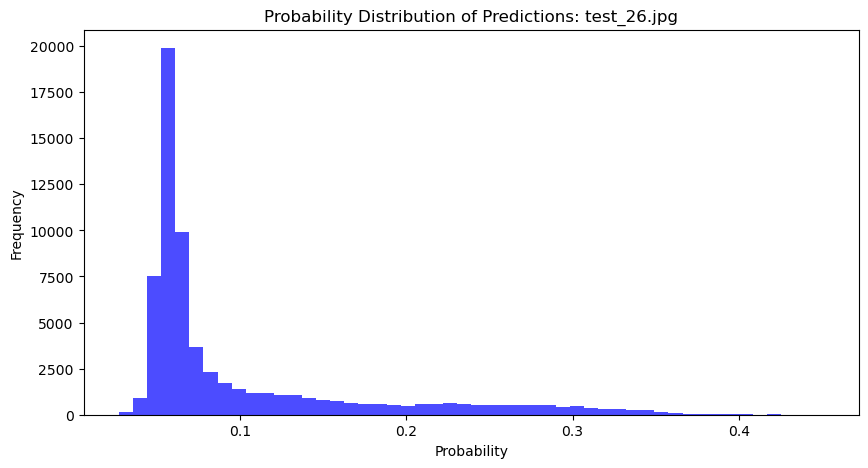

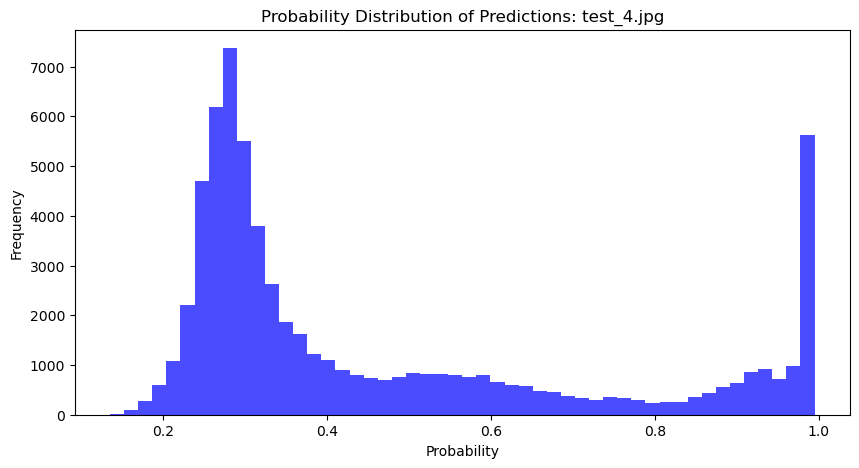

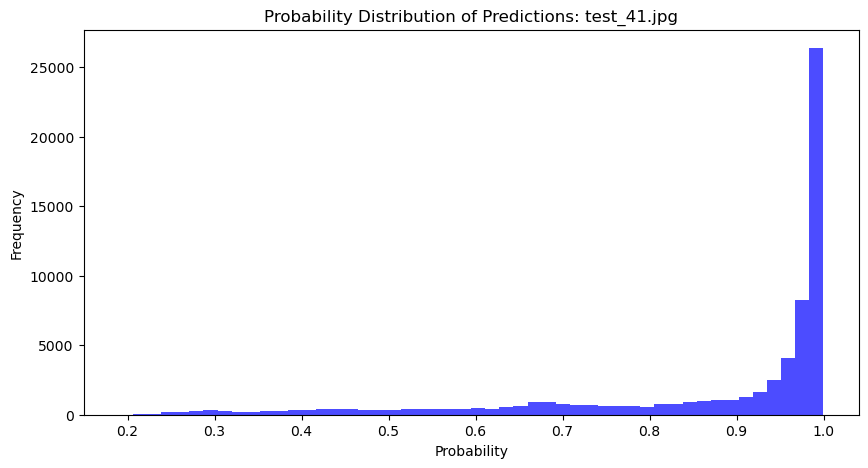

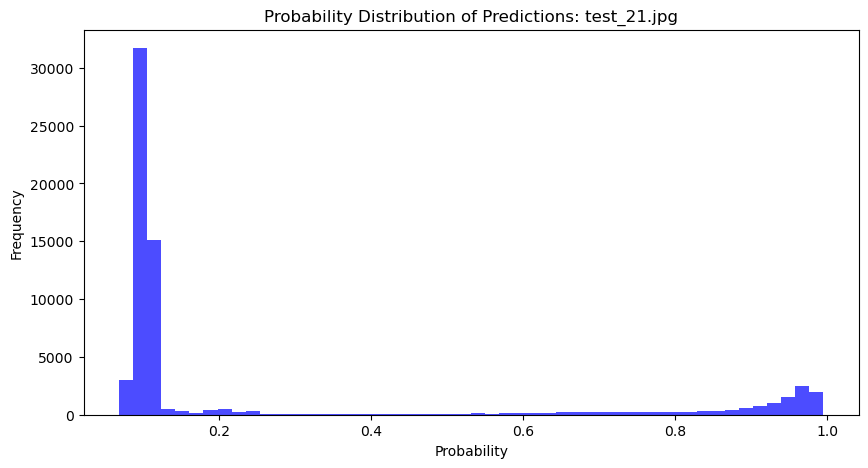

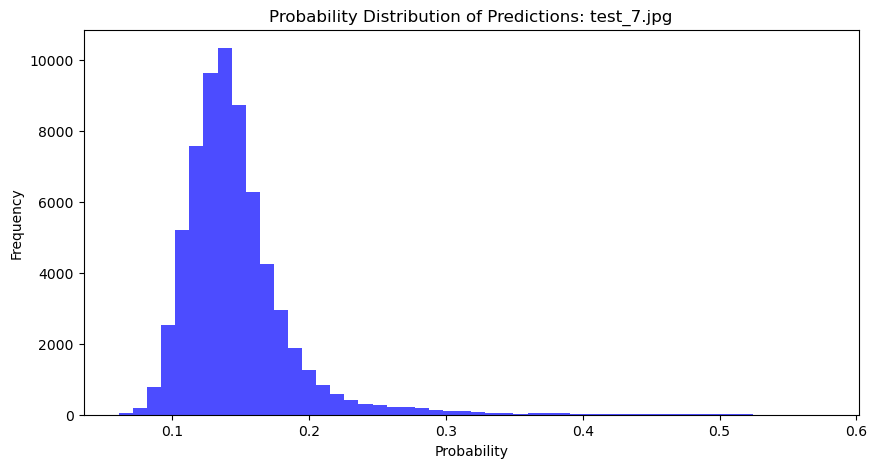

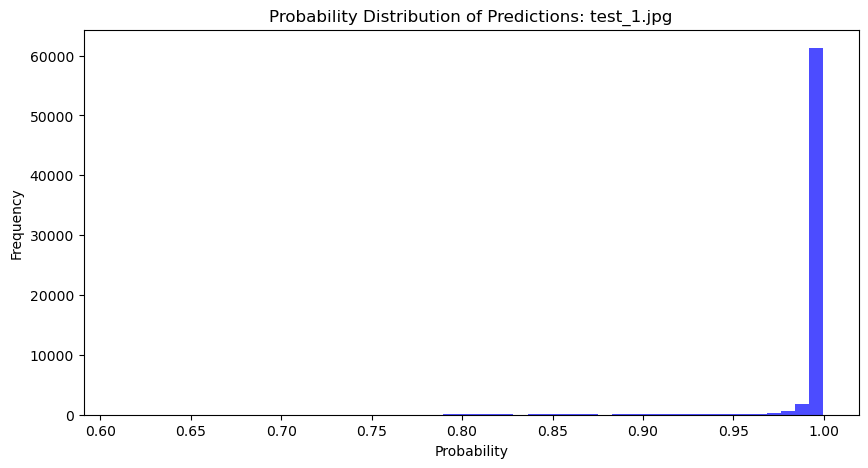

In [7]:
# Function to get raw prediction probabilities
def predict_probabilities(image):
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
        probabilities = output.cpu().numpy()
    return probabilities

# Function to visualize probability distribution
def visualize_probabilities(probabilities):
    plt.figure(figsize=(10, 5))
    plt.hist(probabilities.ravel(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Probability Distribution of Predictions: {image_name}")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.show()
    
# Test the model on the specified images with different thresholds and visualize probabilities
for image_name in test_images:
    image_path = os.path.join(test_images_path, image_name)
    image = load_image(image_path)
    predictions = [predict(image, threshold) for threshold in thresholds]
    #visualize_prediction(image_path, predictions, thresholds)
    
    probabilities = predict_probabilities(image)
    visualize_probabilities(probabilities)

    # Display the best prediction based on the optimal threshold 
    best_prediction = predict(image, 0.5)
    #visualize_prediction(image_path, [best_prediction], [0.5])
